<a href="https://colab.research.google.com/github/Alina972a/drops_area_calculation/blob/main/%D0%9A%D0%B0%D0%BF%D0%BB%D0%B8_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import argparse
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import math

from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import imutils
from keras.preprocessing import image
from PIL import Image as im
from google.colab import files
import csv
import pandas as pd
from google.colab import files

In [2]:
def show_image(img, title):
  
  plt.figure(figsize=(12, 8))
  plt.title(title)
  plt.imshow(img)
  plt.show()


def contrast_and_blurr(img, blurr_block):
  """
  INPUT:
  img - unprocessed RGB image
  OUTPUT: gray_cs - gray normalized and blurred image
  """
  # turn to gray 
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# blur
  gray = cv2.GaussianBlur(gray, blurr_block, 0)
# normalization
  gray_cs = cv2.normalize(gray, None, 0, 255.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  gray_cs = cv2.GaussianBlur(gray_cs, blurr_block, 0)

  return gray_cs


def calculate_drops_area(img, photo_number, blockSize, C):
  '''
  INPUT:
  img - preprocessed image
  blockSize - int, odd numbers only, e.x.: 3, 5, 7, ... - pixel neighborhood size for binary segmentation
  C - int, constant to be substracted before binary segmentation
  
  OUTPUT:
  drop_areas - np.array of shape(k) with calculated areas for each drop
  circularity - np.array of shape(k) with circularity parameters calculated for each drop
  '''

  img = img.astype(np.uint8)
  thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, C) 
  thresh = thresh.astype(np.uint8)
  show_image(thresh, 'binary_image')
  cv2.imwrite('/content/processed_photos/' + str(photo_number + 1) + 'bw' + '.jpg', thresh)

 # detect contours in the mask
  cnts, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL,
          cv2.CHAIN_APPROX_NONE)

  drop_areas = []
  circularity = []

  for k in range(len(cnts)):
    area = cv2.contourArea(cnts[k]) # contourArea считает площадь области, заключенной в контур
    length = cv2.arcLength(cnts[k], True)

    if area > 6.0:
      circ = 4*math.pi*area/(length**2.0)

      if circ > 0.4:
        drop_areas.append(area)
        circularity.append(circ)

  return drop_areas, circularity

In [3]:
def calculate_for_all_photos(photo_number, blockSize, C, blurr_block):
  '''
  INPUT:
  photo_number - int, number of photos
  blockSize - int, odd numbers only, e.x.: 3, 5, 7, ... - pixel neighborhood size for binary segmentation
  C - int, constant to be substracted before binary segmentation

  OUTPUT:
  photo_numbers - np.array of size (k), photo numbers of each processed drop
  area_all - np.array of size (k), area values for all photos
  circularity_all - np.array of size (k), circularity values of all drops
  '''
  area_all = []
  circularity_all = []
  photo_numbers = []
  for i in range(photo_number):
    name = '/content/' + str(i + 1) + '.jpg'
    img = cv2.imread(name)

    gray_cs = contrast_and_blurr(img, blurr_block)
    show_image(gray_cs, 'enhanced contrast')
    cv2.imwrite('/content/processed_photos/' + str(i + 1) + 'contr' + '.jpg', gray_cs)

    areas, circularity = calculate_drops_area(gray_cs, i, blockSize, C)
    photo_numbers = np.concatenate((photo_numbers, i * np.ones(len(areas))))
    circularity_all = np.concatenate((circularity_all, circularity))
    area_all = np.concatenate((area_all, areas))

    print('Площади капель в пикселях:', areas)
    print('circularity:', circularity)

  return photo_numbers, area_all, circularity_all

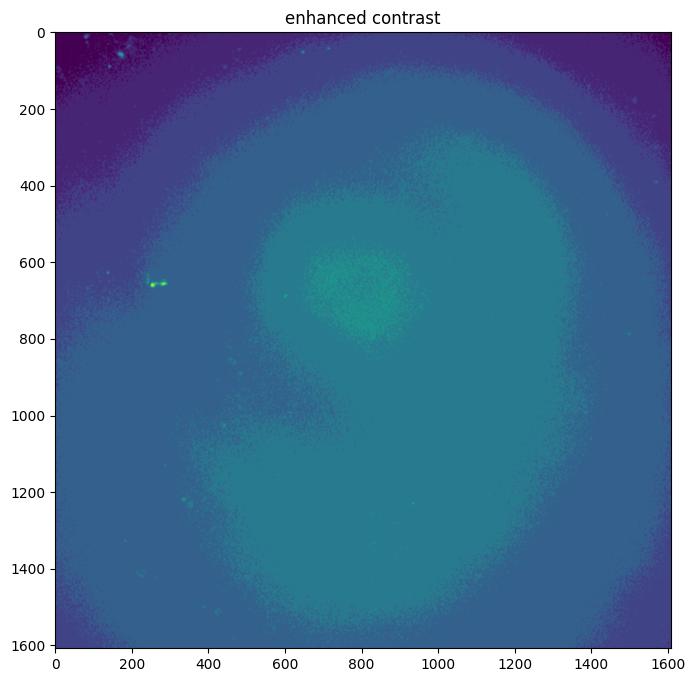

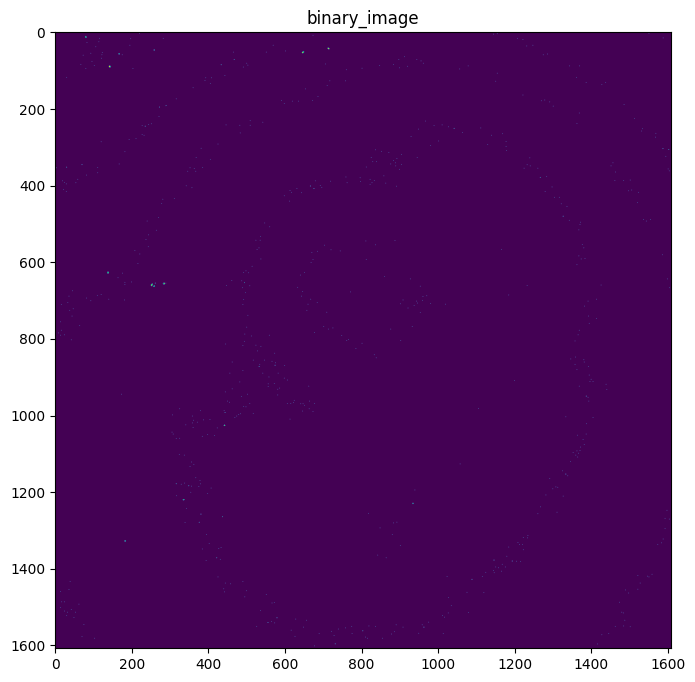

Площади капель в пикселях: [11.0, 8.5, 9.5]
circularity: [0.6587925608735429, 0.8198545354117053, 0.6987331401339559]


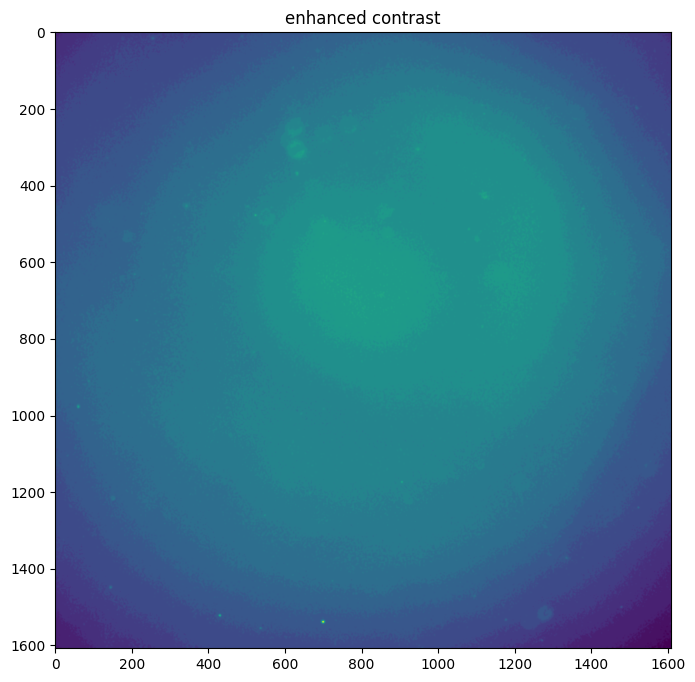

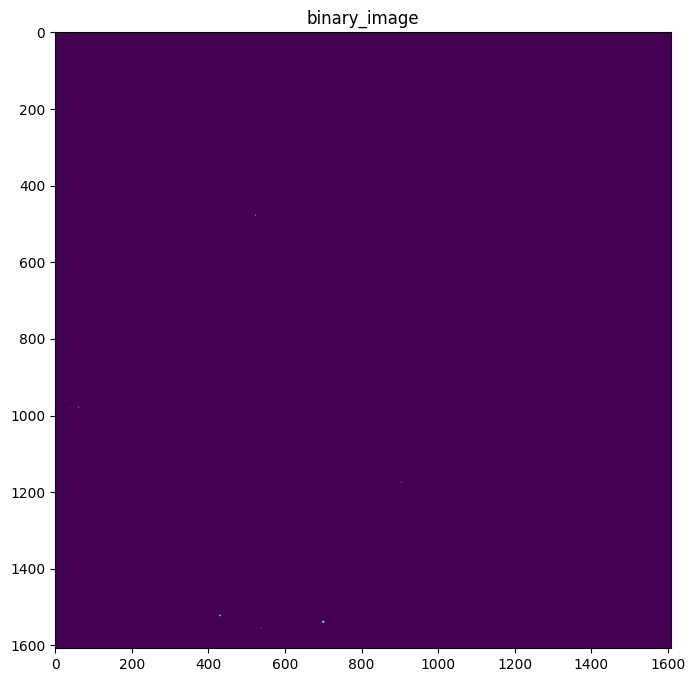

Площади капель в пикселях: [18.0, 8.5]
circularity: [0.9227272726407235, 0.8714646546573355]


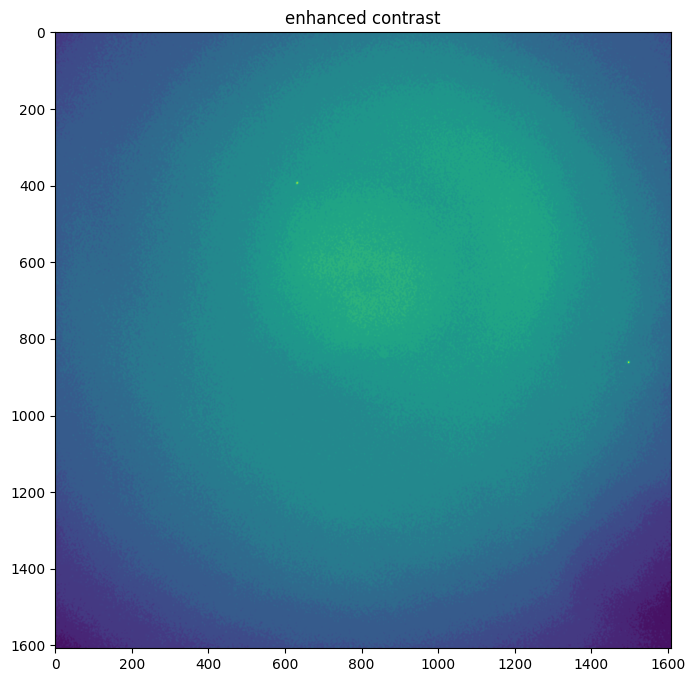

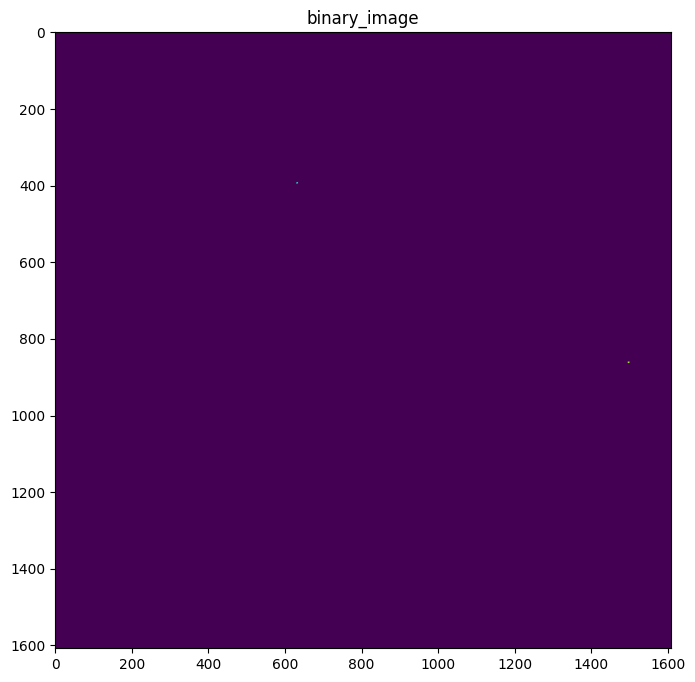

Площади капель в пикселях: [10.0, 6.5]
circularity: [0.9247985466222429, 0.778573021914597]


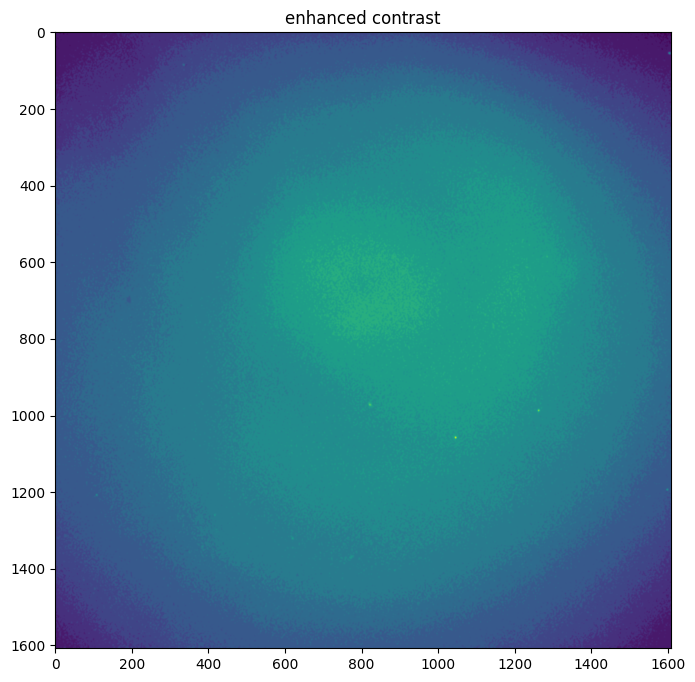

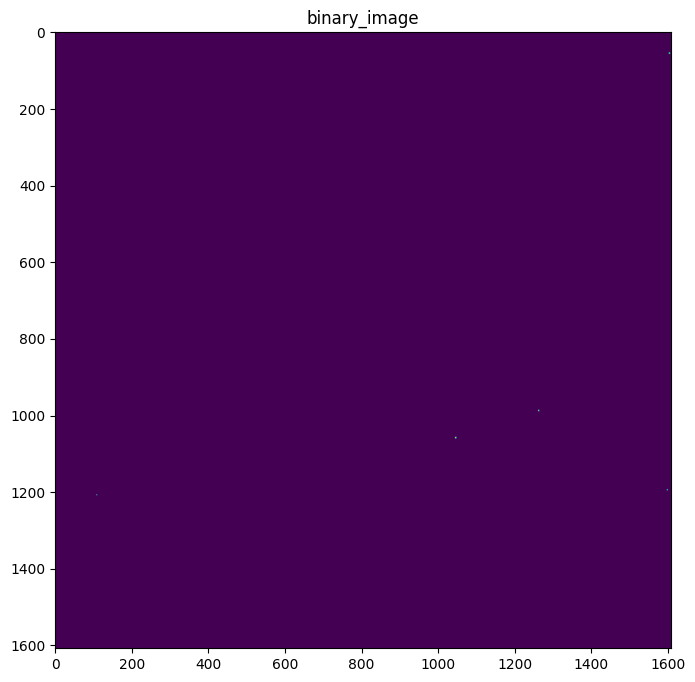

Площади капель в пикселях: [8.0, 7.0]
circularity: [0.8573716100878628, 0.9432711667053002]


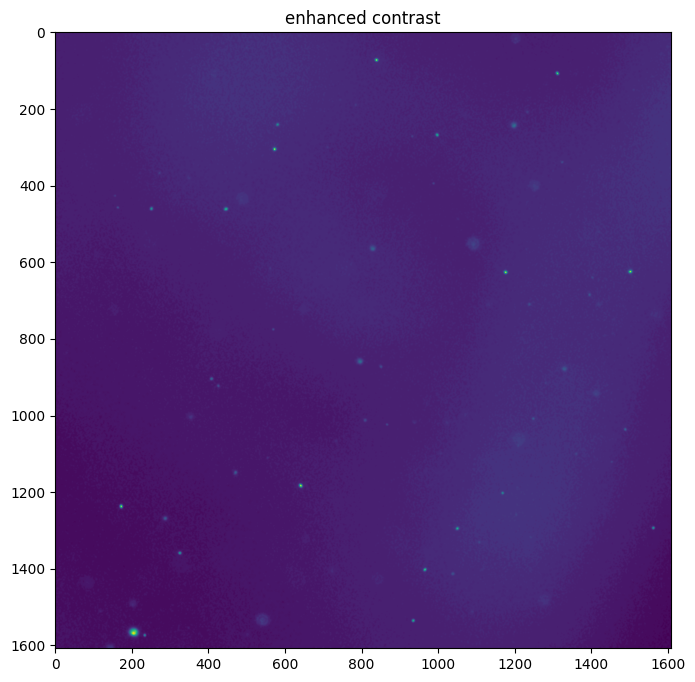

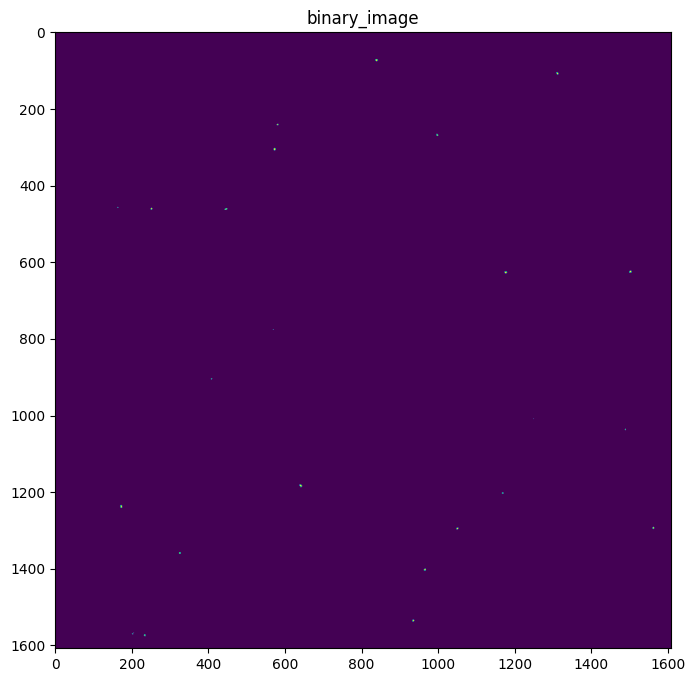

Площади капель в пикселях: [8.0, 11.5, 13.0, 9.0, 10.0, 10.0, 18.0, 21.5, 17.0, 17.0, 12.5, 9.0, 17.0, 9.5, 14.5, 18.0]
circularity: [0.7398388372977943, 0.8458348538463677, 0.8758946496539216, 0.7853981633974483, 0.7635949446159828, 0.9247985466222429, 0.7255305594341376, 0.7703164059084023, 0.8714646463829057, 0.8714646463829057, 0.6915631377813787, 0.8323186919600186, 0.8714646463829057, 0.7964953919549047, 0.8022132398263994, 0.8323186927986581]


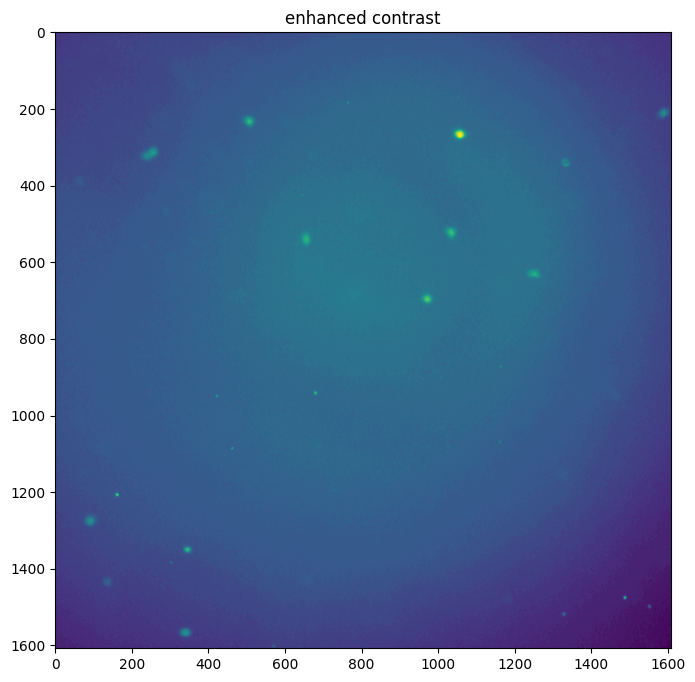

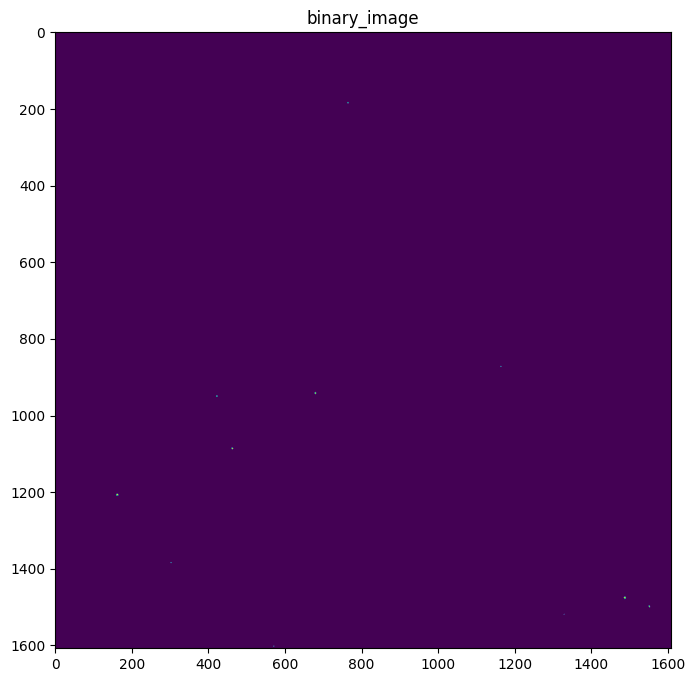

Площади капель в пикселях: [14.5, 13.0, 7.5, 8.0]
circularity: [0.8022132398263994, 0.7429559153356595, 0.8983534868245348, 0.7398388372977943]


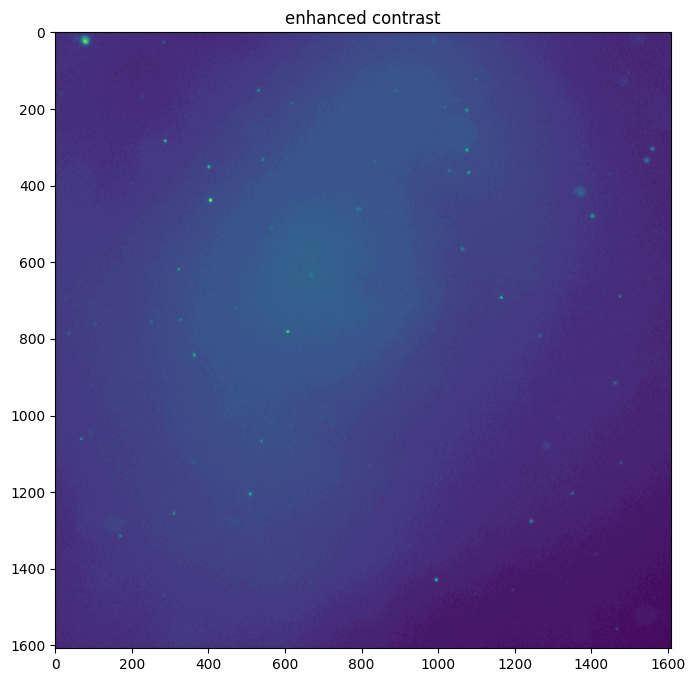

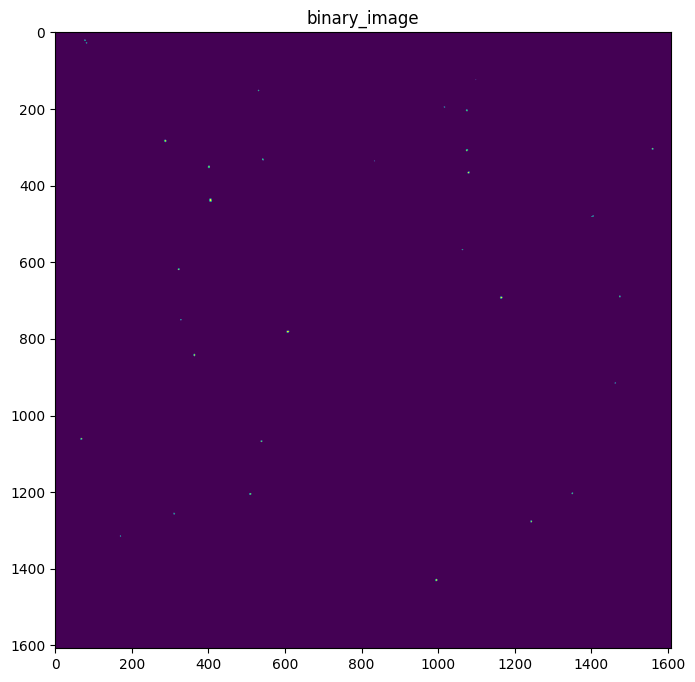

Площади капель в пикселях: [14.5, 8.0, 9.5, 8.0, 10.5, 17.5, 16.5, 8.0, 31.0, 11.5, 14.0, 12.5, 7.0, 15.0, 7.5]
circularity: [0.8982491906543908, 0.7398388372977943, 0.7964953919549047, 0.8573716100878628, 0.7722839969901619, 0.8335557320298667, 0.8202139662830028, 0.8573716100878628, 0.830578747272617, 0.8458348538463677, 0.8384632592936002, 0.9193857107025737, 0.9432711667053002, 0.8037858975970896, 0.768939401168237]


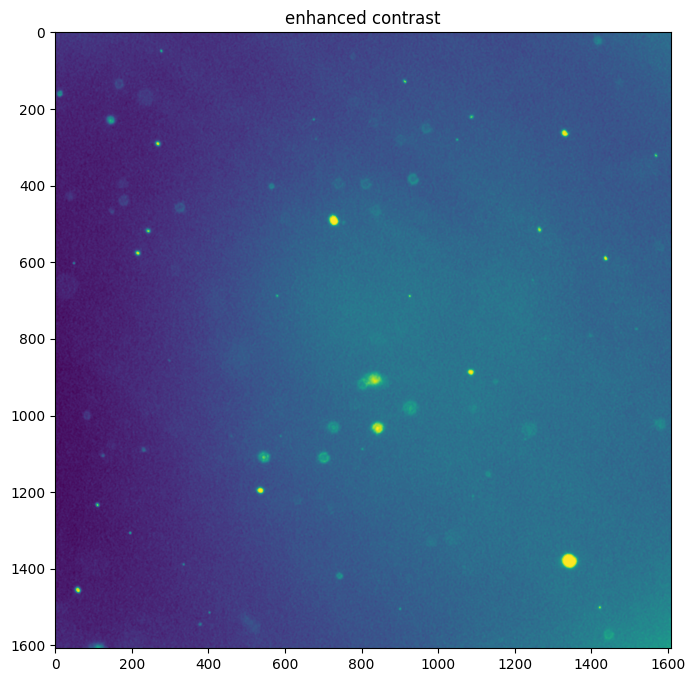

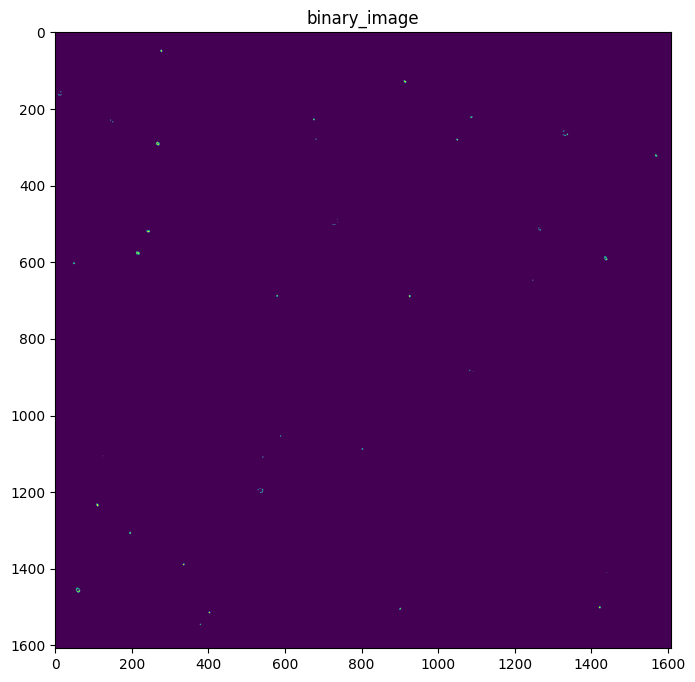

Площади капель в пикселях: [7.5, 7.0, 12.0, 75.0, 8.0, 10.5, 21.5, 11.5, 8.0, 8.5, 41.5, 45.5, 24.5, 13.0, 46.5, 7.5, 7.5, 8.5, 18.5, 13.0]
circularity: [0.8983534868245348, 0.64735898263557, 0.8085181381420814, 0.7025197706433136, 0.8573716100878628, 0.8803370121606843, 0.843270249070409, 0.8031141418478369, 0.8573716100878628, 0.7543480030924008, 0.6867752100185067, 0.8523906481749288, 0.5548300711986753, 0.6664141413516338, 0.8179606879676767, 0.8983534868245348, 0.8983534868245348, 0.62518228327775, 0.6628303957816486, 0.7785730264869145]


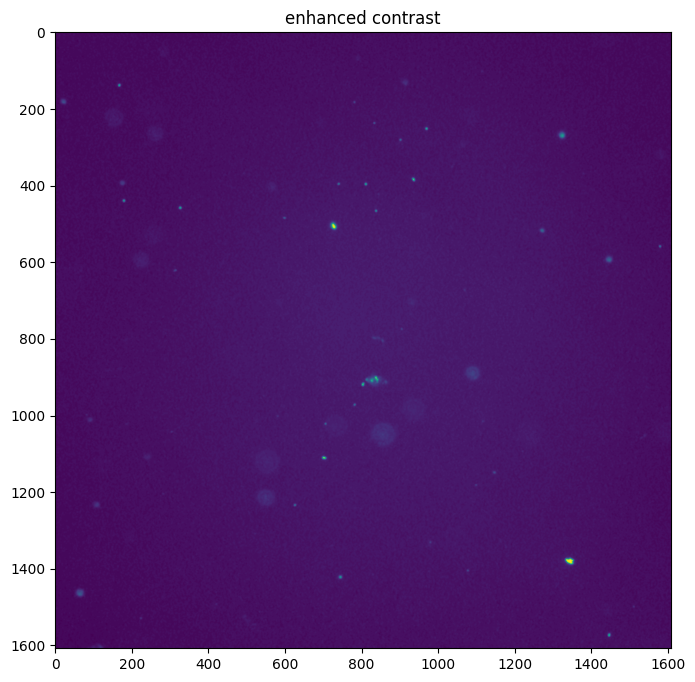

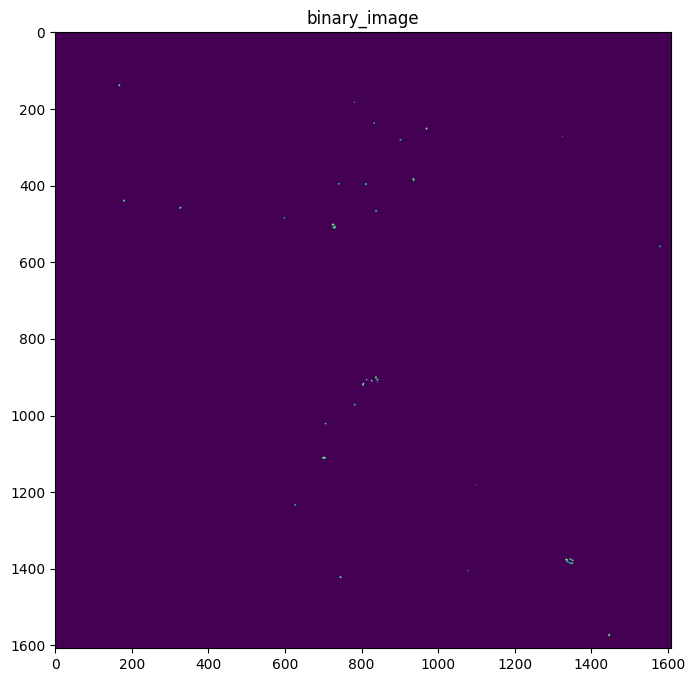

Площади капель в пикселях: [13.5, 11.0, 8.0, 9.0, 25.5, 18.0, 8.0, 7.5, 13.5, 8.5, 10.0, 11.0, 10.0, 6.5, 19.0, 11.0, 10.5]
circularity: [0.746888188803889, 0.8399544390775809, 0.8573716100878628, 0.8323186919600186, 0.602025181947225, 0.6619577098492265, 0.7398388372977943, 0.7234010606573869, 0.8363009706092603, 0.8198545354117053, 0.7635949446159828, 0.8399544390775809, 0.9247985466222429, 0.778573021914597, 0.6400768631214536, 0.8399544390775809, 0.7722839969901619]


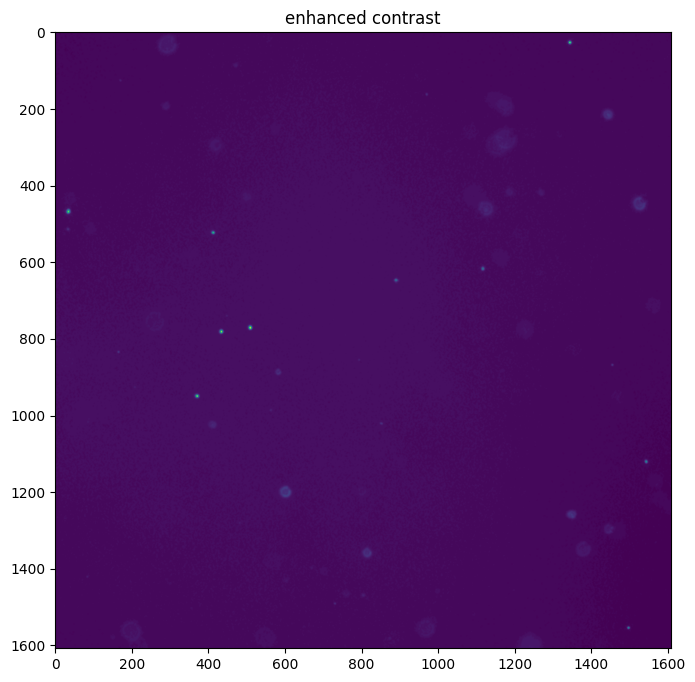

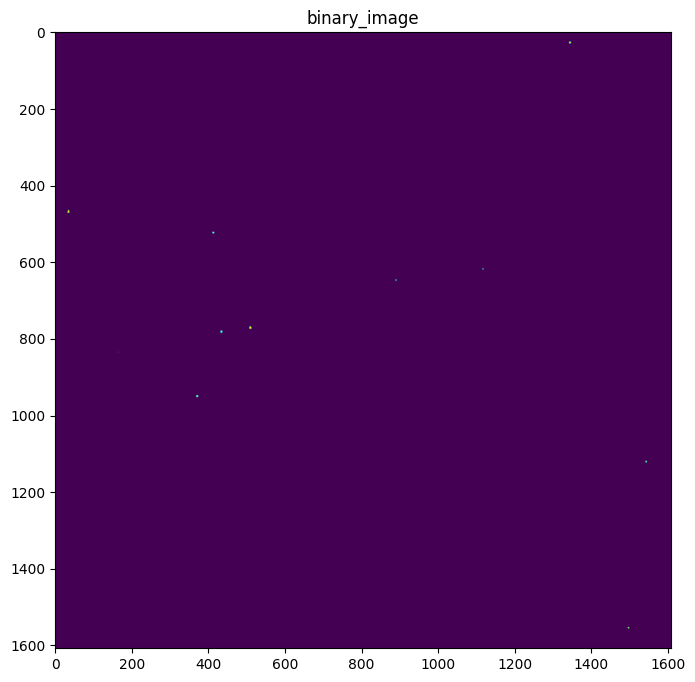

Площади капель в пикселях: [7.5, 9.5, 17.0, 18.5, 24.5, 13.5, 21.5, 17.0]
circularity: [0.8983534868245348, 0.7964953919549047, 0.8714646463829057, 0.881187488145859, 0.8464979936885056, 0.8781032888825034, 0.6822824866852049, 0.8714646463829057]
  adding: content/processed_photos/ (stored 0%)
  adding: content/processed_photos/7bw.jpg (deflated 88%)
  adding: content/processed_photos/8contr.jpg (deflated 0%)
  adding: content/processed_photos/5contr.jpg (deflated 1%)
  adding: content/processed_photos/8bw.jpg (deflated 83%)
  adding: content/processed_photos/1contr.jpg (deflated 3%)
  adding: content/processed_photos/10bw.jpg (deflated 94%)
  adding: content/processed_photos/6contr.jpg (deflated 0%)
  adding: content/processed_photos/3contr.jpg (deflated 0%)
  adding: content/processed_photos/3bw.jpg (deflated 98%)
  adding: content/processed_photos/4contr.jpg (deflated 0%)
  adding: content/processed_photos/7contr.jpg (deflated 0%)
  adding: content/processed_photos/9contr.jpg (defla

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

area  circularity
ind                        
0.0   9.666667     0.725793
1.0  13.250000     0.897096
2.0   8.250000     0.851686
3.0   7.500000     0.900321
4.0  13.468750     0.812532
5.0  10.750000     0.795840
6.0  12.733333     0.835043
7.0  19.775000     0.774711
8.0  11.794118     0.777597
9.0  16.125000     0.840731

In [4]:
# change only these four parameters
photos_number = 10 # total number of photos to be processed
blockSize = 3 # should be an odd number: 3, 5, 7,...
C = -3 # a value to be substracted
blurr_block = (5, 5)

!mkdir processed_photos

photo_numbers, area, circularity = calculate_for_all_photos(photos_number, blockSize, C, blurr_block)

df = pd.DataFrame({'ind': photo_numbers, 'area': area, 'circularity': circularity}, index = None)
df1 = df.groupby('ind').mean()

!zip -r '/content/processed_photos.zip' '/content/processed_photos'
files.download('processed_photos.zip') 

df.to_csv('/content/капли_площадь.csv', index=False)
df1